<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Analisi_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEg Recognition: Analisi Dataset**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">In questo notebook viene svolta l'analisi del dataset composto dalla sola prima run del famoso "EEG Motor Movement/Imagery". È possibile trovare informazioni dettagliate riguardo il dataset originale al seguente <a href="https://physionet.org/content/eegmmidb/1.0.0/">link</a>.</p>
<p style="font-size:4px;" align="justify">Oltre che poter osservare gli elementi principali, è possibile svolgere delle analisi specifiche a relativi campioni e volontari.</p>

<font size=4>**Indice:**</font>
*   [Import librerie](#1)
*   [Downloads](#2)
*   [Analisi generale](#3)
*   [Conclusioni post analisi](#4)

<a name="1"></a>
# **Import librerie**

Iniziamo installando la libreria MNE, essenziale per l'analisi di dati EEG grazie alla sua gestione di file in formato EDF.
I file EDF (European Data Format) sono uno standard ampiamente utilizzato per la memorizzazione di dati EEG (elettroencefalografici). Il formato EDF è uno standard aperto, ben documentato e ampiamente accettato in ambito neuroscientifico che permette la gestione di dati multi-canale (diversi elettrodi EEG) e in cui è possibile includere informazioni aggiuntive (metadati) che descrivono i dati registrati (informazioni aggiuntive non presenti nel nosto dataset).

In [3]:
%%capture
# evita l' output a video
!pip install mne

Importiamo le librerie e montiamo Google Drive per garantire l'accesso agli altri file.

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
import json
import sys
import mne
import os

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="2"></a>
# **Download**

In [6]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:
PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE

In [7]:
sys.path.append(PERCORSO_DRIVE)                       # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset

Preleviamo dal file "EEG_Motor_Movement-Imagery_R01_ID.json" l'ID necessario per il download del dataset.

In [8]:
with open(PERCORSO_DRIVE + '/EEG_Motor_Movement-Imagery_R01_ID.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [9]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:
DATASET_NAME = 'EEG_Motor_Movement-Imagery_R01.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH
From (redirected): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH&confirm=t&uuid=1faa2779-d753-4be8-9df0-86f677af394d
To: /content/EEG_Motor_Movement-Imagery_R01.zip
100%|██████████| 76.6M/76.6M [00:03<00:00, 22.9MB/s]


File scaricato e salvato come EEG_Motor_Movement-Imagery_R01.zip!



Dopo aver scaricato il dataset lo unzippiamo ed eliminiamo i file txt e la cartella sample_data creata automaticamente da Colab.

In [10]:
%%capture

! unzip "{DATASET_NAME}"              # unzippa il file zip
! rm /content/*.zip                   # elimina i file txt
! rm -r /content/sample_data          # elimina la cartella di default di Colab

<a name="3"></a>
# **Analisi Dataset**

Iniziamo creando una tabella contenente tutti gli aspetti utili a svolgere una analisi principale del dataset.

In [11]:
#@title Tabella con informazioni generali
dataset_path = '/content/EEG_T0/'
files = sorted(os.listdir(dataset_path))
tabella_info = []
for i, file in enumerate(files):
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{file}", preload=True, verbose='CRITICAL')
    info = {
        'File': file,
        'Numero Campioni': raw_data.n_times,
        'Frequenza Campionamento (Hz)': raw_data.info['sfreq'],
        'Numero Canali': len(raw_data.info['ch_names']),
        'Durata (s)': raw_data.n_times / raw_data.info['sfreq']
    }
    tabella_info.append(info)

df_info = pd.DataFrame(tabella_info)
display(df_info)

,File,Numero Campioni,Frequenza Campionamento (Hz),Numero Canali,Durata (s)
0,S001R01.edf,9760,160.0,64,61.0
1,S002R01.edf,9760,160.0,64,61.0
2,S003R01.edf,9760,160.0,64,61.0
3,S004R01.edf,9760,160.0,64,61.0
4,S005R01.edf,9760,160.0,64,61.0
...,...,...,...,...,...
104,S105R01.edf,9760,160.0,64,61.0
105,S106R01.edf,9760,160.0,64,61.0
106,S107R01.edf,9760,160.0,64,61.0
107,S108R01.edf,9760,160.0,64,61.0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Esplicitiamo il numero di volontari (classi nel nostro caso) presenti nel dataset.

In [12]:
#@title Numero di classi
numero_classi = len(df_info)
print(f"Numero di classi (volontari): {numero_classi}")

Numero di classi (volontari): 109


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Verifichiamo la quantità di campioni presenti per ogni classe al fine di stabilire il bilanciamento del dataset.

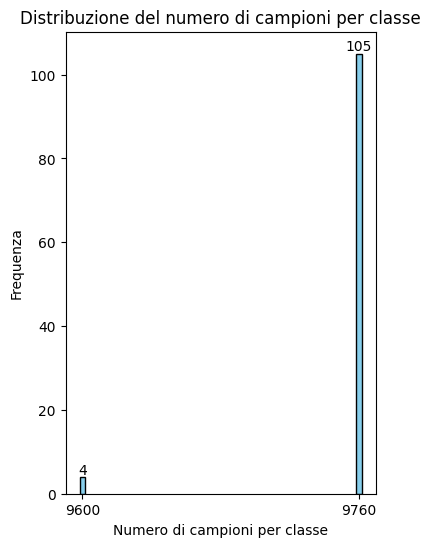

In [13]:
#@title Campioni per classe
# Conta la frequenza di ciascun numero di campioni
campioni_per_classe = Counter(df_info['Numero Campioni'])

# Ottieni i numeri di campioni (x) e le loro frequenze (y)
x = list(campioni_per_classe.keys())
y = list(campioni_per_classe.values())

# Genera il bar chart
plt.figure(figsize=(4, 6))
bars = plt.bar(x, y, width=3.0, align='center', color='skyblue', edgecolor='black')
plt.xlabel("Numero di campioni per classe")
plt.ylabel("Frequenza")
plt.title("Distribuzione del numero di campioni per classe")
plt.xticks(x)  # Mostra tutte le etichette sull'asse x

# Aggiungi i valori sopra ogni barra
for bar, freq in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.show()

Possiamo facilmente notare come il dataset risulti quasi perfettamente bilanciato con la presenza di sole 4 classi aventi un numero di campioni leggermente differente.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Come mostrato in questa <a href="https://physionet.org/content/eegmmidb/1.0.0/64_channel_sharbrough.pdf">figura</a>, li EEG sono stati registrati da 64 elettrodi secondo il sistema internazionale 10-10 ad una frequenza di campionamento pari a 160 Hz. La run utilizzata nel nostro dataset prevede una durata di un minuto più un secondo extra comune nei protocolli sperimentali al fine di garantire la stabilità e sincronizzazione dei segnali.

In [14]:
#@title Report valori anomali

#Verifichiamo che tutti i file abbiano lo stesso numero di canali, la stessa frequenza di campionamento e la stessa durata andando a confrontare ogni valore con la moda

report = {
    "Numero Canali Differenti": df_info[df_info['Numero Canali'] != df_info['Numero Canali'].mode()[0]],
    "Frequenza Campionamento Differente": df_info[df_info['Frequenza Campionamento (Hz)'] != df_info['Frequenza Campionamento (Hz)'].mode()[0]],
    "Durata Differente": df_info[df_info['Durata (s)'] != df_info['Durata (s)'].mode()[0]]
}

# Stampiamo tutti i valori che sono risultati anomali
for key, value in report.items():
    if not value.empty:
        print(f"{key}:")
        display(value)
    else:
        print(f"Tutti i file hanno {key.split(' ')[0].lower()} coerente.")

print(f"La sessione comune di run dura {df_info['Durata (s)'].mode()[0]} secondi")

Tutti i file hanno numero coerente.
Tutti i file hanno frequenza coerente.
Durata Differente:


,File,Numero Campioni,Frequenza Campionamento (Hz),Numero Canali,Durata (s)
13,S014R01.edf,9600,160.0,64,60.0
50,S051R01.edf,9600,160.0,64,60.0
68,S069R01.edf,9600,160.0,64,60.0
108,S109R01.edf,9600,160.0,64,60.0


La sessione comune di run dura 61.0 secondi


Come è normale che sia, si riscontra la coerenza nella frequenza di campionamento e numero di canali utilizzati. Gli unici valori "anomali" presenti riguardano i 4 volontari aventi meno campioni. Ciò è dovuto dalla durata minore di una secondo della loro sessione di run rispetto a quella comune a tutti gli altri volontari.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

La Power Spectral Density (PSD) è una delle analisi di base più utilizzate negli studi EEG per comprendere la distribuzione delle frequenze nel segnale in quanto aiuta a identificare canali rumorosi o saturi, e verificare la qualità del segnale.
Qui di seguito viene utilizzata la PSD media ottenuta da ciascuno volonatrio per ogni canale. Questa aiuta a ottenere una rappresentazione generale della distribuzione delle frequenze nel dataset e per analizzare la coerenza delle risposte EEG a livello di gruppo.

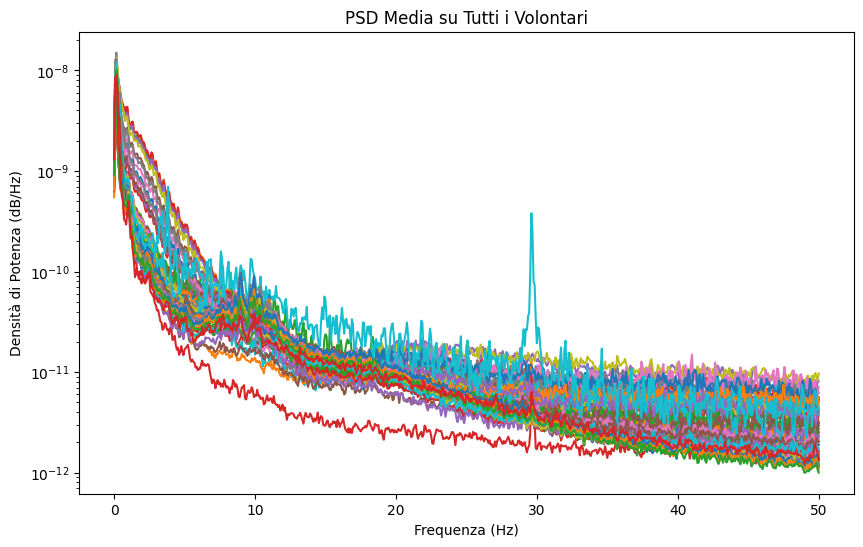

In [15]:
#@title Valutazione della Coerenza delle Frequenze nel Dataset tramite la PSD media per canale

psd_totale = None
psd_frequenze = None

for file in files:
    raw_data = mne.io.read_raw_edf(f"{dataset_path}/{file}", preload=True, verbose='CRITICAL')
    psd, freqs = raw_data.compute_psd(fmax=50, verbose=False).get_data(return_freqs=True)  # Calcola la PSD e ottieni le frequenze

    # Somma la PSD per ciascun volontario
    if psd_totale is None:
        psd_totale = psd
        psd_frequenze = freqs
    else:
        psd_totale += psd

# Calcola la media della PSD
psd_media = psd_totale / numero_classi

# Visualizza la PSD media
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.yscale('log')  # Imposta una scala logaritmica sull'asse delle potenze
plt.plot(psd_frequenze, psd_media.T)  # PSD media per ogni canale
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title('PSD Media su Tutti i Volontari')
plt.show()


I segnali EEG tendono naturalmente ad avere potenza più alta alle frequenze basse. Questo è dovuto sia alla natura del segnale cerebrale stesso sia al fatto che i segnali ad alta frequenza vengono attenuati in modo più significativo nel passaggio attraverso il cranio e il cuoio capelluto. Per questo motivo è stata scelta una scala logaritmica per l'asse delle ordinate, permettendo così una visione più dettagliata delle frequenze più alte.

Con il prossimo grafico a barre è possibile vedere la distribuzione della potenza media divisa per le bande di frequenza più comunemente studiate nei segnali EEG.

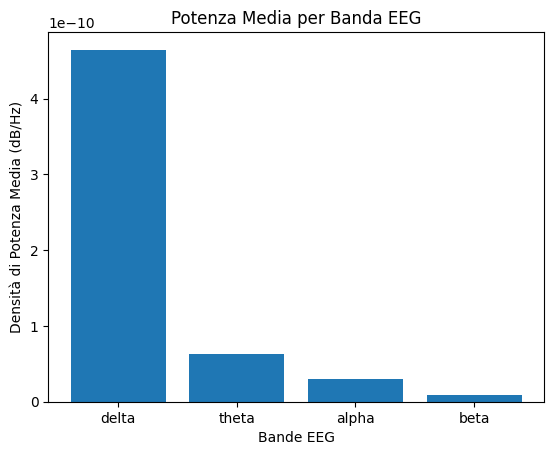

In [16]:
# Esempio per calcolare e visualizzare la potenza media per bande
bande = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}

potenza_bande = {}
for banda, limiti in bande.items():
    # Seleziona le frequenze all'interno della banda
    indici_frequenze = (psd_frequenze >= limiti[0]) & (psd_frequenze <= limiti[1])

    # Calcola la potenza media per la banda su tutti i canali
    # .mean(axis=1) calcola la media lungo la dimensione delle frequenze (axis=1)
    # .mean() calcola la media su tutti i canali
    potenza_bande[banda] = np.mean(psd_media[:, indici_frequenze].mean(axis=1))

plt.bar(potenza_bande.keys(), potenza_bande.values())
plt.xlabel('Bande EEG')
plt.ylabel('Densità di Potenza Media (dB/Hz)')
plt.title('Potenza Media per Banda EEG')
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Per permettere una analisi più approfondita riguardo uno specifico EEG, qui di seguito è possibile iterare sui file di ciascun volontario.

In [17]:
#@title Seleziona il volontario per cui vuoi effettuare ulteriori analisi
#@markdown Inserisci il numero del volontario (1-109):
volontario = 2 #@param {type:"integer"}
file = files[volontario-1]
raw_data = mne.io.read_raw_edf(f"{dataset_path}/{file}", preload=True, verbose='CRITICAL')


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

La PSD di uno specifico EEG permette di osservare la distribuzione delle frequenze di ciascun volontario singolarmente e di fare un confronto visivo tra loro.

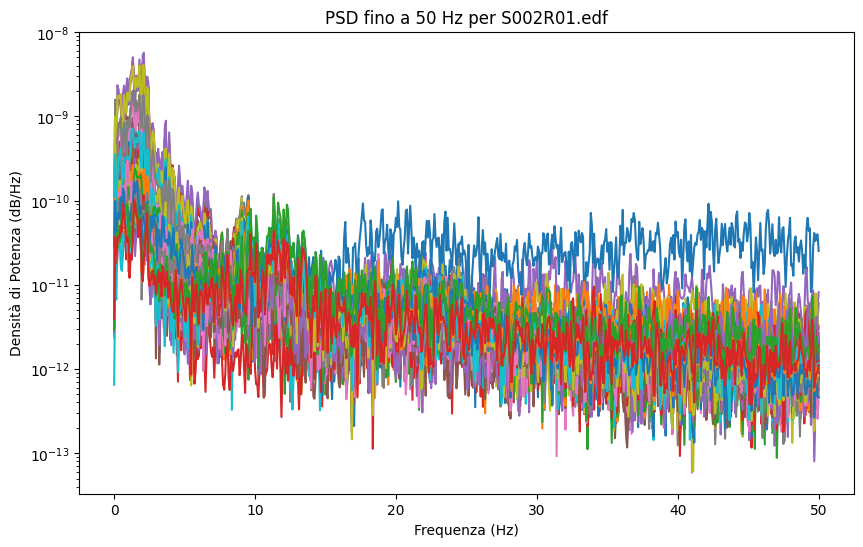

In [18]:
#@title PSD per canale per singolo volontario

# Calcola la PSD usando il metodo `compute_psd`
psd_data = raw_data.compute_psd(fmax=50, verbose=False)

# Ottieni i dati della PSD e le frequenze
psd, freqs = psd_data.get_data(return_freqs=True)

# Visualizza la PSD per ogni canale
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd.T)  # Trasponiamo `psd` per avere ogni canale su una linea separata
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Densità di Potenza (dB/Hz)')
plt.title(f'PSD fino a 50 Hz per {file}')
plt.yscale('log')  # Imposta la scala logaritmica se necessario
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Un boxplot per ciascun canale di un singolo EEG fornisce una panoramica generale della distribuzione e della variabilità del segnale, mostrando se ci sono valori fuori scala o canali con ampiezze insolite.

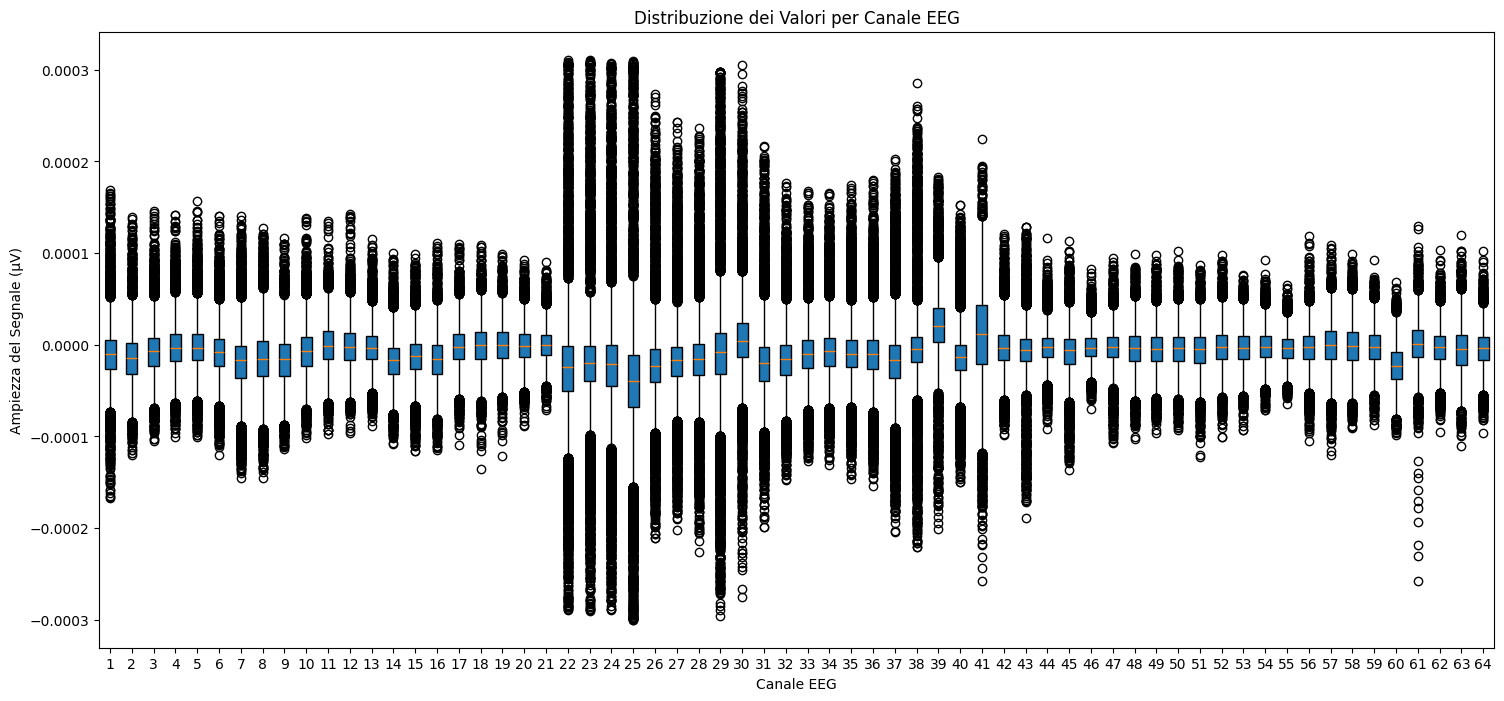

In [19]:
#@title Boxplot per canale per singolo volontario

data = raw_data.get_data()  # Dimensioni: (n_channels, n_times)

# Creare un boxplot per ciascun canale
plt.figure(figsize=(18, 8))
plt.boxplot(data.T, patch_artist=True)
plt.xlabel("Canale EEG")
plt.ylabel("Ampiezza del Segnale (μV)")
plt.title("Distribuzione dei Valori per Canale EEG")
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Con il codice successivo è possibile effettuare lo spettrogramma, utile ad analizzare come le frequenze variano nel tempo grazie e individuare eventuali cambiamenti dinamici nel segnale EEG.

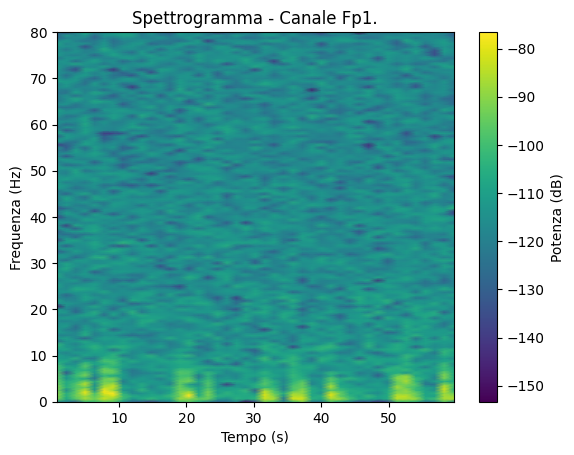

In [20]:
#@title Seleziona il canale per cui vuoi effettuare lo spettrogramma
#@markdown Inserisci il numero del canale (1-64):
canale = 22 #@param {type:"integer"}
canale -= 1
# Genera uno spettrogramma per il canale selezionato del volontario scelto
f, t, Sxx = spectrogram(data[canale, :], fs=raw_data.info['sfreq'])

plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequenza (Hz)')
plt.xlabel('Tempo (s)')
plt.title(f'Spettrogramma - Canale {raw_data.info["ch_names"][canale]}')
plt.colorbar(label='Potenza (dB)')
plt.show()

Per permettere una visione più chiara viene offerta anche una prospettiva 3D dello stesso spettrogramma.

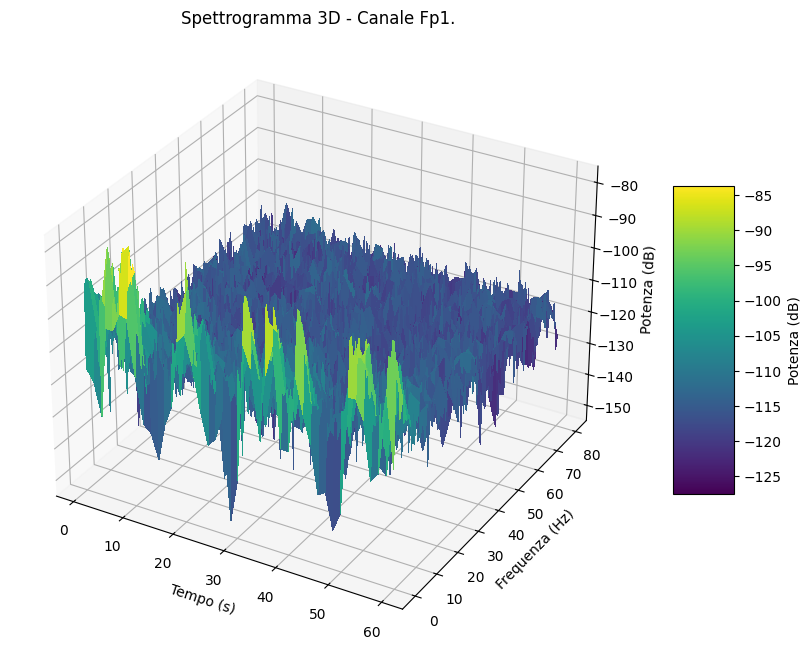

In [21]:
# Crea una figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Crea una meshgrid per le coordinate X e Y
T, F = np.meshgrid(t, f)

# Plotta la superficie 3D
surf = ax.plot_surface(T, F, 10 * np.log10(Sxx), cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Imposta le etichette degli assi
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequenza (Hz)')
ax.set_zlabel('Potenza (dB)')
ax.set_title(f'Spettrogramma 3D - Canale {raw_data.info["ch_names"][canale]}')

# Aggiungi una colorbar
fig.colorbar(surf, shrink=0.5, aspect=5, label='Potenza (dB)')

plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Infine viene calcolata la matrice di correlazione tra i canali, utile per rilevare ridondanza nei segnali.

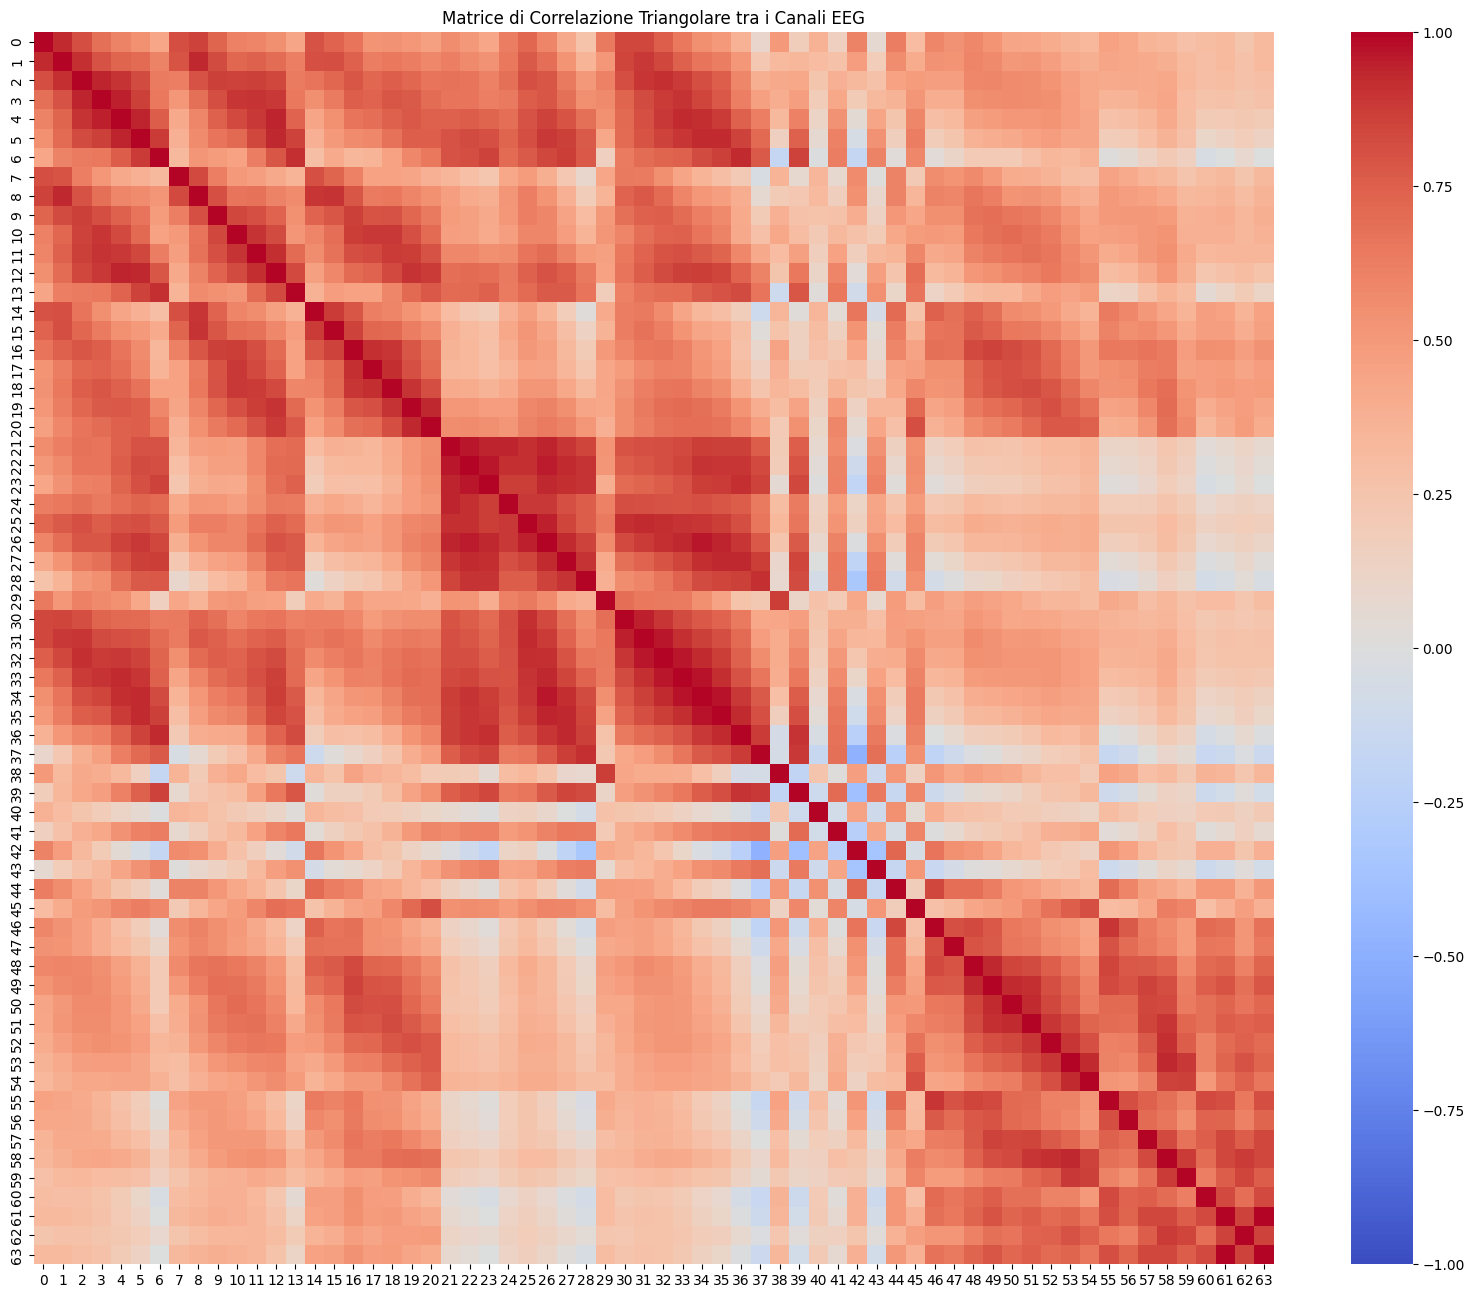

In [22]:
# Calcola la matrice di correlazione tra canali
corr_matrix = pd.DataFrame(data).T.corr()

# Plot della matrice di correlazione triangolare
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di Correlazione Triangolare tra i Canali EEG")
plt.show()

<a name="4"></a>
# **Conclusioni post analisi**